In [298]:
import os
import json
import yaml
import time
from redis import Redis
from rq import Queue, Retry
from rq.job import Job
import traceback
import sys
import networkx as nx
import warnings
import matplotlib.cbook
from joyflo import reactflow_to_networkx

In [299]:
from FUNCTIONS.GENERATORS import *
from FUNCTIONS.TRANSFORMERS import *
from FUNCTIONS.VISORS import *
from FUNCTIONS.CONDITIONALS import *

In [300]:
stream = open('STATUS_CODES.yml', 'r',encoding="utf8")
STATUS_CODES = yaml.safe_load(stream)

from utils import PlotlyJSONEncoder

import os

REDIS_HOST = os.environ.get('REDIS_HOST', 'localhost')
REDIS_PORT = os.environ.get('REDIS_PORT', 6379)

#### *Configuring Redis*

In [301]:
r = Redis(host=REDIS_HOST, port=REDIS_PORT)
q = Queue('flojoy', connection=r)

In [302]:
# Load React flow chart object from JSON file

f = open('./test-fc.json')
fc = json.loads(f.read())
elems = fc['elements']

#### *Configuring NETWORKX*

In [303]:
DG = nx.DiGraph()
DG.clear()

#### *Converting the elements to nodes*

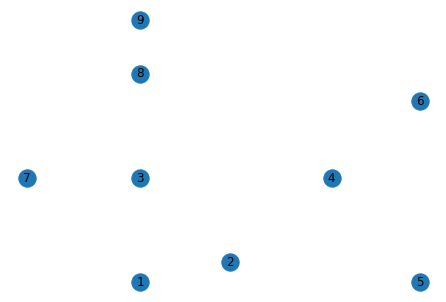

In [304]:
for i in range(len(elems)):
    el = elems[i]
    if 'source' not in el:
        data = el['data']
        ctrls = data['ctrls'] if 'ctrls' in data else {}
        DG.add_node(i+1, pos=(el['position']['x'], el['position']['y']), id=el['id'], ctrls=ctrls)
        elems[i]['index'] = i+1
        elems[i]['label'] = el['id'].split('-')[0]

pos = nx.get_node_attributes(DG,'pos')
nx.draw(DG, pos, with_labels=True)

#### *Adding Edges*

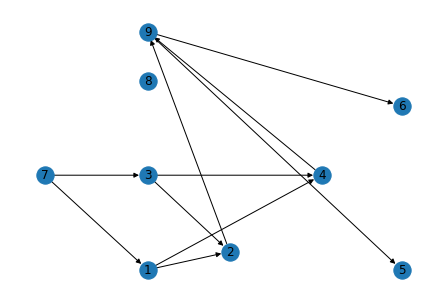

In [305]:
edge_label_dict = {}
def get_tuple(edge):
    e = [-1, -1]
    src_id = edge['source']
    tgt_id = edge['target']

    type = edge['type']
    if type == 'special':
        label = edge['label']
    else:
        label = 'default'
    if tgt_id not in edge_label_dict.keys():
        edge_label_dict[tgt_id] = []
    edge_label_dict[tgt_id].append({
        'source': src_id,
        'label':label
    })

    # iterate through all nodes looking for matching edge
    for el in elems:
        if 'id' in el:
            if el['id'] == src_id:
                e[0] = el['index']
            elif el['id'] == tgt_id:
                e[1] = el['index']
    return tuple(e)

for i in range(len(elems)):
    el = elems[i]
    if 'source' in el:
        # element is an edge
        e = get_tuple(el)
        DG.add_edge(*e)
nx.draw(DG, pos, with_labels=True)
# print(edge_label_dict)

#### *Adding Labels to each nodes*

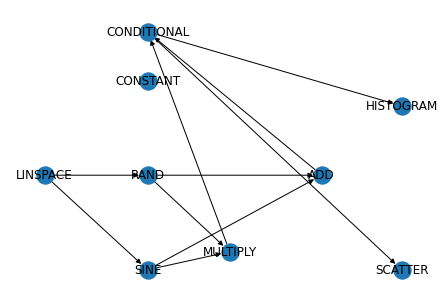

In [306]:
labels = {}
type = {}

for el in elems:
    # if element is not a node
    if 'source' not in el:
        labels[el['index']] = el['data']['label']
        type[el['index']] = el['type']
                
nx.set_node_attributes(DG, labels, 'cmd')
nx.set_node_attributes(DG, type,'type')
nx.draw(DG, pos, with_labels=True, labels = labels)

#### *UTIL FUNCTIONS*

In [307]:
def get_node_data_by_id():
    nodes_by_id = dict()
    for n, nd in DG.nodes().items():
        nodes_by_id[n] = nd
    return nodes_by_id

def report_failure(job, connection, type, value, traceback):
    print(job, connection, type, value, traceback)

def jid(n):
    return 'JOB_ID_{0}'.format(n)

topological_sorting = nx.topological_sort(DG)
nodes_by_id = get_node_data_by_id()

#### TESTING THE CONSTRUCTED GRAPH

In [308]:
for n, nd in DG.nodes().items():
    print('node', n, 'node data', nd)

for node in nx.topological_sort(DG):
    print(node)

node 1 node data {'pos': (291, 105), 'id': 'SINE-userGeneratedNode_1646417316016', 'ctrls': {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}}, 'cmd': 'SINE', 'type': 'default'}
node 2 node data {'pos': (523, 135), 'id': 'MULTIPLY-userGeneratedNode_1646417352715', 'ctrls': {}, 'cmd': 'MULTIPLY', 'type': 'default'}
node 3 node data {'pos': (291, 262), 'id': 'RAND-userGeneratedNode_1646417371398', 'ctrls': {}, 'cmd': 'RAND', 'type': 'default'}
node 4 node data {'pos': (783, 262), 'id': 'ADD-userGeneratedNode_1646417428589', 'ctrls': {}, 'cmd': 'ADD', 'type': 'default'}
node 5 node data {'pos': (1009, 105), 'id': 'SCATTER-userGeneratedNode_1646417560399', 'ctrls': {}, 'cmd': 'SCATTER', 'type': 'default'}
node 6 node data {'pos': (1009, 377), 'id': 'HISTOGRAM-userGeneratedNode_1646417604301'

In [309]:
def check_predecessor(n):
    successful_jobs_count = 0
    predecessor_count = 0
    predecessor_payloads = []
    for p in DG.predecessors(n):
        predecessor_count = predecessor_count + 1
        job_id = jid(p)
        # print("predecessor, ",job_id)
        try:
            job = Job.fetch(job_id, connection=r)
            nd = nodes_by_id[p]
        except Exception:
            print(traceback.format_exc())

        attempt_count,is_any_node_failed = 0,False
        while True:
            time.sleep(0.5)
            job_status= job.get_status(refresh=True)
            redis_payload = job.result
            attempt_count += 1
            print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
            
            if job_status == 'finished':
                successful_jobs_count = successful_jobs_count + 1
                predecessor_payloads.append(redis_payload)
                break
            if is_any_node_failed:
                print('canceling', nd['cmd'], 'due to failure in another node')
                job.delete()
                job_status = "cancelled"
                break
            if job_status == 'failed':
                is_any_node_failed = True
                break
            if job_status == 'deferred':
                registry = q.deferred_job_registry
                registry.requeue(job_id)
    print(str(is_any_node_failed))
    return successful_jobs_count == predecessor_count,predecessor_payloads

In [310]:
'''
    TODO all types of registries, deferred, failed, finished.
'''

def handle_special_type_node(node_serial,node_label):

    if node_label == "CONDITIONAL":
        status,payloads = check_predecessor(node_serial)
        
        if status and len(payloads) == 2:
            return {'payload':payloads[0],'label':'true'}   
        

In [311]:
edge_label_dict

{'SINE-userGeneratedNode_1646417316016': [{'source': 'LINSPACE-userGeneratedNode_1646432683694',
   'label': 'default'}],
 'RAND-userGeneratedNode_1646417371398': [{'source': 'LINSPACE-userGeneratedNode_1646432683694',
   'label': 'default'}],
 'ADD-userGeneratedNode_1646417428589': [{'source': 'SINE-userGeneratedNode_1646417316016',
   'label': 'default'},
  {'source': 'RAND-userGeneratedNode_1646417371398', 'label': 'default'}],
 'MULTIPLY-userGeneratedNode_1646417352715': [{'source': 'SINE-userGeneratedNode_1646417316016',
   'label': 'default'},
  {'source': 'RAND-userGeneratedNode_1646417371398', 'label': 'default'}],
 'CONDITIONAL-userGeneratedNode_1646435677929': [{'source': 'ADD-userGeneratedNode_1646417428589',
   'label': 'default'},
  {'source': 'MULTIPLY-userGeneratedNode_1646417352715', 'label': 'default'}],
 'HISTOGRAM-userGeneratedNode_1646417604301': [{'source': 'CONDITIONAL-userGeneratedNode_1646435677929',
   'label': 'true'}],
 'SCATTER-userGeneratedNode_164641756039

In [312]:
def find_edge_label(source_id,destination_id):
    for key, value in edge_label_dict.items():
        if key == destination_id:
            for ind_value in value:
                if ind_value['source'] == source_id:
                    return ind_value['label']
    return None

In [313]:
def check_eligibity_collect_result(node_serial,flow_direction,enqued_jobs_list):
    '''
        TODO Check Predecessor:
             - IF any Predecessor is special type, then check edge label, if both true, then pass the 
    '''
    previous_job_ids = []
    is_eligible = True
    for p in DG.predecessors(node_serial):
        type = nodes_by_id[p]['type']
        if type == 'special':
            # checking edge label
            source_id = nodes_by_id[p]['id']
            destination_id = nodes_by_id[node_serial]['id']
            label = find_edge_label(source_id,destination_id)

            if (flow_direction is not None) and (label != flow_direction):
                return {'is_eligible':False,'predecessor':[]}
        else:
            job_id = jid(p)
            if job_id not in enqued_jobs_list:
                return {'is_eligible':False,'predecessor':[]}
            else:
                previous_job_ids.append(job_id)
    return {'is_eligible':is_eligible,'predecessor':previous_job_ids}

In [314]:
total_enqued_node = 0
enqued_jobs_list = []
labeled_edge = "true"
is_eligible_to_enqued = True
special_type_node_payload = None
flow_direction = None

for n in nx.topological_sort(DG):
    cmd,ctrls,type = get_node_data_by_id()[n]['cmd'],get_node_data_by_id()[n]['ctrls'],get_node_data_by_id()[n]['type']

    # print('node:', n, 'ctrls:', ctrls, "cmd: ", cmd, "type: ",type)
    job_id = jid(n)
    func = getattr(globals()[cmd], cmd)

    if(type == 'special'):
        return_value = handle_special_type_node(node_serial = n,node_label = cmd)
        special_type_node_payload,flow_direction = return_value['payload'],return_value['label']
    else:
        s = ' '.join([STATUS_CODES['JOB_IN_RQ'], cmd.upper()])
        r.set('SYSTEM_STATUS', s)

        '''
            TODO: MUST CHECK PREDECESSORS IF ANYONE OF THEM IS SPECIAL TYPE NODES OR NOT
        '''

        if len(list(DG.predecessors(n))) == 0:
            # print('{0} ({1}) has no predecessors'.format(cmd, n))
            q.enqueue(func,
                retry=Retry(max=100), # TODO: have to understand why the SINE node is failing for few times then succeeds
                job_timeout='3m',
                on_failure=report_failure,
                job_id = job_id,
                kwargs={'ctrls': ctrls},
                result_ttl=500)
            print('ENQUEUING...', cmd, job_id, ctrls)
        else:
            result = check_eligibity_collect_result(node_serial=n,flow_direction=flow_direction,enqued_jobs_list = enqued_jobs_list)
            is_eligible,previous_job_ids = result['is_eligible'],result['predecessor']

            print(special_type_node_payload)

            if is_eligible:
                q.enqueue(func,
                    retry=Retry(max=100),
                    job_timeout='3m',
                    on_failure=report_failure,
                    job_id=job_id,
                    kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids,'special_type_node_result':special_type_node_payload},
                    depends_on=previous_job_ids,
                    result_ttl=500)
                print('ENQUEUING...', cmd, job_id, ctrls, previous_job_ids)

        total_enqued_node = total_enqued_node + 1
        enqued_jobs_list.append(job_id)

ENQUEUING... LINSPACE JOB_ID_7 {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}
ENQUEUING... CONSTANT JOB_ID_8 {'CONSTANT_2.0_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}, 'CONSTANT_8_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}}
None
ENQUEUING... SINE JOB_ID_1 {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}} ['JOB_ID_7']
None
ENQUEUING... RAND JOB_ID_3 {} ['JOB_ID_7']
None
ENQUEUING... ADD JOB_ID_4 {} ['JOB_ID_1', 'JOB_ID_3']
None
ENQUEUING... MULTIPLY JOB_ID_2 {} ['JOB_ID_1', 'JOB_ID_3']
Job status: ADD deferred origin: floj

In [315]:
try:
    job = Job.fetch('JOB_ID_7', connection=r)
    job_status= job.get_status(refresh=True)
    print('Status: %s' % job_status)
except Exception:
    print("no such jobs")

Status: finished


In [316]:
registry = q.failed_job_registry
print(registry.get_job_ids())

['JOB_ID_18', 'JOB_ID_7', 'JOB_ID_5', 'JOB_ID_6']





Getting Node Outputs
Job status: LINSPACE finished origin: flojoy attempt: 1
Job status: CONSTANT finished origin: flojoy attempt: 1
Job status: SINE finished origin: flojoy attempt: 1
Job status: RAND finished origin: flojoy attempt: 1
Job status: ADD finished origin: flojoy attempt: 1
Job status: MULTIPLY finished origin: flojoy attempt: 1
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_10232\1689592644.py", line 14, in <module>
    job = Job.fetch(job_id, connection=r)
  File "c:\Users\User\miniconda3\envs\dev\lib\site-packages\rq\job.py", line 350, in fetch
    job.refresh()
  File "c:\Users\User\miniconda3\envs\dev\lib\site-packages\rq\job.py", line 591, in refresh
    raise NoSuchJobError('No such job: {0}'.format(self.key))
rq.exceptions.NoSuchJobError: No such job: b'rq:job:JOB_ID_9'

Job status: CONDITIONAL finished origin: flojoy attempt: 1
Job status: HISTOGRAM started origin: flojoy attempt: 1
Job status: HISTOGRAM queued origin: flo

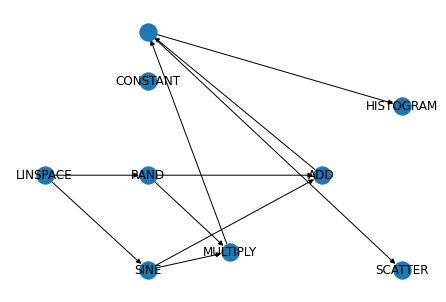

In [236]:
all_node_results = []
topological_sorting = reactflow_to_networkx(elems)['topological_sort']

print('\n\n')
print("Getting Node Outputs")

is_any_node_failed = False
for n in topological_sorting:
    job_id = jid(n)
    nd = nodes_by_id[n]
    # TODO have to investigate if and why this fails sometime
    # best is to remove this try catch, so we will have to come back to it soon
    try:
        job = Job.fetch(job_id, connection=r)
    except Exception:
        print(traceback.format_exc())
    job_status, redis_payload, attempt_count = None, None, 0
    while True: # or change it to wait for maximum amount of time, then we can declare job timed out
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        redis_payload = job.result
        attempt_count += 1

        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        if attempt_count > 9:
            job.delete()
            break
        if job_status == 'finished':
            break
        if is_any_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break
        if job_status == 'failed':
            is_any_node_failed = True
            break
        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)

    all_node_results.append({'cmd': nd['cmd'], 'id': nd['id'], 'result':redis_payload, 'job_status': job_status})
# print(all_node_results)

In [320]:
kwargs={'ctrls': {},'previous_job_ids':[],'special_type_node_result':{'x0':[ 1.        ,  1.01301301,  1.02602603,  1.03903904,  1.05205205,
        1.06506507,  1.07807808,  1.09109109,  1.1041041 ,  1.11711712,
        1.13013013,  1.14314314,  1.15615616,  1.16916917,  1.18218218,
        1.1951952 ,  1.20820821,  1.22122122,  1.23423423,  1.24724725,
        1.26026026,  1.27327327,  1.28628629,  1.2992993 ,  1.31231231,
        1.32532533,  1.33833834,  1.35135135,  1.36436436,  1.37737738,
        1.39039039,  1.4034034 ,  1.41641642,  1.42942943,  1.44244244,
        1.45545546,  1.46846847,  1.48148148,  1.49449449,  1.50750751,
        1.52052052,  1.53353353,  1.54654655,  1.55955956,  1.57257257,
        1.58558559,  1.5985986 ,  1.61161161,  1.62462462,  1.63763764,
        1.65065065,  1.66366366,  1.67667668,  1.68968969,  1.7027027 ,
        1.71571572,  1.72872873,  1.74174174,  1.75475475,  1.76776777,
        1.78078078,  1.79379379,  1.80680681,  1.81981982,  1.83283283,
        1.84584585,  1.85885886,  1.87187187,  1.88488488,  1.8978979 ,
        1.91091091,  1.92392392,  1.93693694,  1.94994995,  1.96296296,
        1.97597598,  1.98898899,  2.002002  ,  2.01501502,  2.02802803,
        2.04104104,  2.05405405,  2.06706707,  2.08008008,  2.09309309,
        2.10610611,  2.11911912,  2.13213213,  2.14514515,  2.15815816,
        2.17117117,  2.18418418,  2.1971972 ,  2.21021021,  2.22322322,
        2.23623624,  2.24924925,  2.26226226,  2.27527528,  2.28828829,
        2.3013013 ,  2.31431431,  2.32732733,  2.34034034,  2.35335335,
        2.36636637,  2.37937938,  2.39239239,  2.40540541,  2.41841842,
        2.43143143,  2.44444444,  2.45745746,  2.47047047,  2.48348348,
        2.4964965 ,  2.50950951,  2.52252252,  2.53553554,  2.54854855,
        2.56156156,  2.57457457,  2.58758759,  2.6006006 ,  2.61361361,
        2.62662663,  2.63963964,  2.65265265,  2.66566567,  2.67867868,
        2.69169169,  2.7047047 ,  2.71771772,  2.73073073,  2.74374374,
        2.75675676,  2.76976977,  2.78278278,  2.7957958 ,  2.80880881,
        2.82182182,  2.83483483,  2.84784785,  2.86086086,  2.87387387,
        2.88688689,  2.8998999 ,  2.91291291,  2.92592593,  2.93893894,
        2.95195195,  2.96496496,  2.97797798,  2.99099099,  3.004004  ,
        3.01701702,  3.03003003,  3.04304304,  3.05605606,  3.06906907,
        3.08208208,  3.0950951 ,  3.10810811,  3.12112112,  3.13413413,
        3.14714715,  3.16016016,  3.17317317,  3.18618619,  3.1991992 ,
        3.21221221,  3.22522523,  3.23823824,  3.25125125,  3.26426426,
        3.27727728,  3.29029029,  3.3033033 ,  3.31631632,  3.32932933,
        3.34234234,  3.35535536,  3.36836837,  3.38138138,  3.39439439,
        3.40740741,  3.42042042,  3.43343343,  3.44644645,  3.45945946,
        3.47247247,  3.48548549,  3.4984985 ,  3.51151151,  3.52452452,
        3.53753754,  3.55055055,  3.56356356,  3.57657658,  3.58958959,
        3.6026026 ,  3.61561562,  3.62862863,  3.64164164,  3.65465465,
        3.66766767,  3.68068068,  3.69369369,  3.70670671,  3.71971972,
        3.73273273,  3.74574575,  3.75875876,  3.77177177,  3.78478478,
        3.7977978 ,  3.81081081,  3.82382382,  3.83683684,  3.84984985,
        3.86286286,  3.87587588,  3.88888889,  3.9019019 ,  3.91491491,
        3.92792793,  3.94094094,  3.95395395,  3.96696697,  3.97997998,
        3.99299299,  4.00600601,  4.01901902,  4.03203203,  4.04504505,
        4.05805806,  4.07107107,  4.08408408,  4.0970971 ,  4.11011011,
        4.12312312,  4.13613614,  4.14914915,  4.16216216,  4.17517518,
        4.18818819,  4.2012012 ,  4.21421421,  4.22722723,  4.24024024,
        4.25325325,  4.26626627,  4.27927928,  4.29229229,  4.30530531,
        4.31831832,  4.33133133,  4.34434434,  4.35735736,  4.37037037,
        4.38338338,  4.3963964 ,  4.40940941,  4.42242242,  4.43543544,
        4.44844845,  4.46146146,  4.47447447,  4.48748749,  4.5005005 ,
        4.51351351,  4.52652653,  4.53953954,  4.55255255,  4.56556557,
        4.57857858,  4.59159159,  4.6046046 ,  4.61761762,  4.63063063,
        4.64364364,  4.65665666,  4.66966967,  4.68268268,  4.6956957 ,
        4.70870871,  4.72172172,  4.73473473,  4.74774775,  4.76076076,
        4.77377377,  4.78678679,  4.7997998 ,  4.81281281,  4.82582583,
        4.83883884,  4.85185185,  4.86486486,  4.87787788,  4.89089089,
        4.9039039 ,  4.91691692,  4.92992993,  4.94294294,  4.95595596,
        4.96896897,  4.98198198,  4.99499499,  5.00800801,  5.02102102,
        5.03403403,  5.04704705,  5.06006006,  5.07307307,  5.08608609,
        5.0990991 ,  5.11211211,  5.12512513,  5.13813814,  5.15115115,
        5.16416416,  5.17717718,  5.19019019,  5.2032032 ,  5.21621622,
        5.22922923,  5.24224224,  5.25525526,  5.26826827,  5.28128128,
        5.29429429,  5.30730731,  5.32032032,  5.33333333,  5.34634635,
        5.35935936,  5.37237237,  5.38538539,  5.3983984 ,  5.41141141,
        5.42442442,  5.43743744,  5.45045045,  5.46346346,  5.47647648,
        5.48948949,  5.5025025 ,  5.51551552,  5.52852853,  5.54154154,
        5.55455455,  5.56756757,  5.58058058,  5.59359359,  5.60660661,
        5.61961962,  5.63263263,  5.64564565,  5.65865866,  5.67167167,
        5.68468468,  5.6976977 ,  5.71071071,  5.72372372,  5.73673674,
        5.74974975,  5.76276276,  5.77577578,  5.78878879,  5.8018018 ,
        5.81481481,  5.82782783,  5.84084084,  5.85385385,  5.86686687,
        5.87987988,  5.89289289,  5.90590591,  5.91891892,  5.93193193,
        5.94494494,  5.95795796,  5.97097097,  5.98398398,  5.996997  ,
        6.01001001,  6.02302302,  6.03603604,  6.04904905,  6.06206206,
        6.07507508,  6.08808809,  6.1011011 ,  6.11411411,  6.12712713,
        6.14014014,  6.15315315,  6.16616617,  6.17917918,  6.19219219,
        6.20520521,  6.21821822,  6.23123123,  6.24424424,  6.25725726,
        6.27027027,  6.28328328,  6.2962963 ,  6.30930931,  6.32232232,
        6.33533534,  6.34834835,  6.36136136,  6.37437437,  6.38738739,
        6.4004004 ,  6.41341341,  6.42642643,  6.43943944,  6.45245245,
        6.46546547,  6.47847848,  6.49149149,  6.5045045 ,  6.51751752,
        6.53053053,  6.54354354,  6.55655656,  6.56956957,  6.58258258,
        6.5955956 ,  6.60860861,  6.62162162,  6.63463463,  6.64764765,
        6.66066066,  6.67367367,  6.68668669,  6.6996997 ,  6.71271271,
        6.72572573,  6.73873874,  6.75175175,  6.76476476,  6.77777778,
        6.79079079,  6.8038038 ,  6.81681682,  6.82982983,  6.84284284,
        6.85585586,  6.86886887,  6.88188188,  6.89489489,  6.90790791,
        6.92092092,  6.93393393,  6.94694695,  6.95995996,  6.97297297,
        6.98598599,  6.998999  ,  7.01201201,  7.02502503,  7.03803804,
        7.05105105,  7.06406406,  7.07707708,  7.09009009,  7.1031031 ,
        7.11611612,  7.12912913,  7.14214214,  7.15515516,  7.16816817,
        7.18118118,  7.19419419,  7.20720721,  7.22022022,  7.23323323,
        7.24624625,  7.25925926,  7.27227227,  7.28528529,  7.2982983 ,
        7.31131131,  7.32432432,  7.33733734,  7.35035035,  7.36336336,
        7.37637638,  7.38938939,  7.4024024 ,  7.41541542,  7.42842843,
        7.44144144,  7.45445445,  7.46746747,  7.48048048,  7.49349349,
        7.50650651,  7.51951952,  7.53253253,  7.54554555,  7.55855856,
        7.57157157,  7.58458458,  7.5975976 ,  7.61061061,  7.62362362,
        7.63663664,  7.64964965,  7.66266266,  7.67567568,  7.68868869,
        7.7017017 ,  7.71471471,  7.72772773,  7.74074074,  7.75375375,
        7.76676677,  7.77977978,  7.79279279,  7.80580581,  7.81881882,
        7.83183183,  7.84484484,  7.85785786,  7.87087087,  7.88388388,
        7.8968969 ,  7.90990991,  7.92292292,  7.93593594,  7.94894895,
        7.96196196,  7.97497497,  7.98798799,  8.001001  ,  8.01401401,
        8.02702703,  8.04004004,  8.05305305,  8.06606607,  8.07907908,
        8.09209209,  8.10510511,  8.11811812,  8.13113113,  8.14414414,
        8.15715716,  8.17017017,  8.18318318,  8.1961962 ,  8.20920921,
        8.22222222,  8.23523524,  8.24824825,  8.26126126,  8.27427427,
        8.28728729,  8.3003003 ,  8.31331331,  8.32632633,  8.33933934,
        8.35235235,  8.36536537,  8.37837838,  8.39139139,  8.4044044 ,
        8.41741742,  8.43043043,  8.44344344,  8.45645646,  8.46946947,
        8.48248248,  8.4954955 ,  8.50850851,  8.52152152,  8.53453453,
        8.54754755,  8.56056056,  8.57357357,  8.58658659,  8.5995996 ,
        8.61261261,  8.62562563,  8.63863864,  8.65165165,  8.66466466,
        8.67767768,  8.69069069,  8.7037037 ,  8.71671672,  8.72972973,
        8.74274274,  8.75575576,  8.76876877,  8.78178178,  8.79479479,
        8.80780781,  8.82082082,  8.83383383,  8.84684685,  8.85985986,
        8.87287287,  8.88588589,  8.8988989 ,  8.91191191,  8.92492492,
        8.93793794,  8.95095095,  8.96396396,  8.97697698,  8.98998999,
        9.003003  ,  9.01601602,  9.02902903,  9.04204204,  9.05505506,
        9.06806807,  9.08108108,  9.09409409,  9.10710711,  9.12012012,
        9.13313313,  9.14614615,  9.15915916,  9.17217217,  9.18518519,
        9.1981982 ,  9.21121121,  9.22422422,  9.23723724,  9.25025025,
        9.26326326,  9.27627628,  9.28928929,  9.3023023 ,  9.31531532,
        9.32832833,  9.34134134,  9.35435435,  9.36736737,  9.38038038,
        9.39339339,  9.40640641,  9.41941942,  9.43243243,  9.44544545,
        9.45845846,  9.47147147,  9.48448448,  9.4974975 ,  9.51051051,
        9.52352352,  9.53653654,  9.54954955,  9.56256256,  9.57557558,
        9.58858859,  9.6016016 ,  9.61461461,  9.62762763,  9.64064064,
        9.65365365,  9.66666667,  9.67967968,  9.69269269,  9.70570571,
        9.71871872,  9.73173173,  9.74474474,  9.75775776,  9.77077077,
        9.78378378,  9.7967968 ,  9.80980981,  9.82282282,  9.83583584,
        9.84884885,  9.86186186,  9.87487487,  9.88788789,  9.9009009 ,
        9.91391391,  9.92692693,  9.93993994,  9.95295295,  9.96596597,
        9.97897898,  9.99199199, 10.00500501, 10.01801802, 10.03103103,
       10.04404404, 10.05705706, 10.07007007, 10.08308308, 10.0960961 ,
       10.10910911, 10.12212212, 10.13513514, 10.14814815, 10.16116116,
       10.17417417, 10.18718719, 10.2002002 , 10.21321321, 10.22622623,
       10.23923924, 10.25225225, 10.26526527, 10.27827828, 10.29129129,
       10.3043043 , 10.31731732, 10.33033033, 10.34334334, 10.35635636,
       10.36936937, 10.38238238, 10.3953954 , 10.40840841, 10.42142142,
       10.43443443, 10.44744745, 10.46046046, 10.47347347, 10.48648649,
       10.4994995 , 10.51251251, 10.52552553, 10.53853854, 10.55155155,
       10.56456456, 10.57757758, 10.59059059, 10.6036036 , 10.61661662,
       10.62962963, 10.64264264, 10.65565566, 10.66866867, 10.68168168,
       10.69469469, 10.70770771, 10.72072072, 10.73373373, 10.74674675,
       10.75975976, 10.77277277, 10.78578579, 10.7987988 , 10.81181181,
       10.82482482, 10.83783784, 10.85085085, 10.86386386, 10.87687688,
       10.88988989, 10.9029029 , 10.91591592, 10.92892893, 10.94194194,
       10.95495495, 10.96796797, 10.98098098, 10.99399399, 11.00700701,
       11.02002002, 11.03303303, 11.04604605, 11.05905906, 11.07207207,
       11.08508509, 11.0980981 , 11.11111111, 11.12412412, 11.13713714,
       11.15015015, 11.16316316, 11.17617618, 11.18918919, 11.2022022 ,
       11.21521522, 11.22822823, 11.24124124, 11.25425425, 11.26726727,
       11.28028028, 11.29329329, 11.30630631, 11.31931932, 11.33233233,
       11.34534535, 11.35835836, 11.37137137, 11.38438438, 11.3973974 ,
       11.41041041, 11.42342342, 11.43643644, 11.44944945, 11.46246246,
       11.47547548, 11.48848849, 11.5015015 , 11.51451451, 11.52752753,
       11.54054054, 11.55355355, 11.56656657, 11.57957958, 11.59259259,
       11.60560561, 11.61861862, 11.63163163, 11.64464464, 11.65765766,
       11.67067067, 11.68368368, 11.6966967 , 11.70970971, 11.72272272,
       11.73573574, 11.74874875, 11.76176176, 11.77477477, 11.78778779,
       11.8008008 , 11.81381381, 11.82682683, 11.83983984, 11.85285285,
       11.86586587, 11.87887888, 11.89189189, 11.9049049 , 11.91791792,
       11.93093093, 11.94394394, 11.95695696, 11.96996997, 11.98298298,
       11.995996  , 12.00900901, 12.02202202, 12.03503504, 12.04804805,
       12.06106106, 12.07407407, 12.08708709, 12.1001001 , 12.11311311,
       12.12612613, 12.13913914, 12.15215215, 12.16516517, 12.17817818,
       12.19119119, 12.2042042 , 12.21721722, 12.23023023, 12.24324324,
       12.25625626, 12.26926927, 12.28228228, 12.2952953 , 12.30830831,
       12.32132132, 12.33433433, 12.34734735, 12.36036036, 12.37337337,
       12.38638639, 12.3993994 , 12.41241241, 12.42542543, 12.43843844,
       12.45145145, 12.46446446, 12.47747748, 12.49049049, 12.5035035 ,
       12.51651652, 12.52952953, 12.54254254, 12.55555556, 12.56856857,
       12.58158158, 12.59459459, 12.60760761, 12.62062062, 12.63363363,
       12.64664665, 12.65965966, 12.67267267, 12.68568569, 12.6986987 ,
       12.71171171, 12.72472472, 12.73773774, 12.75075075, 12.76376376,
       12.77677678, 12.78978979, 12.8028028 , 12.81581582, 12.82882883,
       12.84184184, 12.85485485, 12.86786787, 12.88088088, 12.89389389,
       12.90690691, 12.91991992, 12.93293293, 12.94594595, 12.95895896,
       12.97197197, 12.98498498, 12.997998  , 13.01101101, 13.02402402,
       13.03703704, 13.05005005, 13.06306306, 13.07607608, 13.08908909,
       13.1021021 , 13.11511512, 13.12812813, 13.14114114, 13.15415415,
       13.16716717, 13.18018018, 13.19319319, 13.20620621, 13.21921922,
       13.23223223, 13.24524525, 13.25825826, 13.27127127, 13.28428428,
       13.2972973 , 13.31031031, 13.32332332, 13.33633634, 13.34934935,
       13.36236236, 13.37537538, 13.38838839, 13.4014014 , 13.41441441,
       13.42742743, 13.44044044, 13.45345345, 13.46646647, 13.47947948,
       13.49249249, 13.50550551, 13.51851852, 13.53153153, 13.54454454,
       13.55755756, 13.57057057, 13.58358358, 13.5965966 , 13.60960961,
       13.62262262, 13.63563564, 13.64864865, 13.66166166, 13.67467467,
       13.68768769, 13.7007007 , 13.71371371, 13.72672673, 13.73973974,
       13.75275275, 13.76576577, 13.77877878, 13.79179179, 13.8048048 ,
       13.81781782, 13.83083083, 13.84384384, 13.85685686, 13.86986987,
       13.88288288, 13.8958959 , 13.90890891, 13.92192192, 13.93493493,
       13.94794795, 13.96096096, 13.97397397, 13.98698699, 14.        ], 'y0':[ 6.22254036e-01, -7.47653163e-01,  1.78518089e+00, -1.03802129e+00,
       -2.54470777e+00,  5.59615832e-01,  1.67914838e+00, -1.90240088e-01,
        3.96996171e-01, -1.25739781e+00,  1.14663230e+00,  2.13641603e-01,
        1.11401742e+00,  3.55761445e-01,  7.65643212e-01,  1.50379347e-01,
        3.34052559e-01, -3.73658615e-01,  4.83493769e-01,  1.38829388e+00,
        1.95726504e+00,  9.99198829e-01,  2.36630028e-01,  3.42764194e-01,
       -1.43509747e-01,  6.75686269e-01,  9.55419279e-01, -4.11751538e-01,
       -8.01180703e-02, -1.16390880e-01,  1.08725198e+00, -2.99275633e-01,
        1.00147122e+00,  5.92792759e-01,  8.66381535e-01,  2.81726059e-01,
        1.47765976e+00,  5.74623506e-01, -3.74217869e-01,  1.20948126e-01,
        7.39832502e-01,  6.63034029e-01,  8.07059168e-01,  1.40644545e-01,
       -9.73906191e-01,  1.44987552e+00,  1.50851493e+00,  8.70574231e-01,
       -4.24445081e-01,  2.96272538e+00,  1.02828903e+00, -6.60581780e-01,
        1.55601077e+00,  2.62571403e+00,  2.57416017e+00, -1.12916186e+00,
       -1.22614927e-01, -4.92165154e-01,  4.24878402e-01,  2.50507313e+00,
        1.39766391e+00, -3.08713689e-01,  3.54661904e-01,  1.33219304e-01,
        6.18759410e-01,  9.31840526e-01, -5.03008206e-01,  1.36498413e+00,
        1.73186007e+00,  3.75697540e+00, -2.76626816e-01,  1.54869876e+00,
        3.61963619e+00,  1.11828342e+00,  1.75081538e-01, -4.06117886e-02,
        1.53986385e+00,  2.21895380e-01,  1.06368907e+00,  4.32196617e-01,
       -4.82139965e-01,  1.77942262e-01, -4.16105882e-01,  1.75219075e+00,
        1.76493650e+00, -8.82498146e-01, -8.11111044e-01, -5.69603421e-01,
        1.08615422e+00,  8.90285920e-01,  6.00647913e-02,  1.14849754e+00,
       -3.65501606e-01, -3.04956802e-01,  1.84012452e+00, -2.79874609e-01,
        1.31265734e+00, -4.05742102e-01,  8.74245735e-01,  2.88550282e+00,
        1.92500958e+00,  8.62172216e-01,  1.10870498e+00,  8.82205931e-01,
        1.54141252e+00, -3.19926653e-01,  1.89679830e+00,  2.39254934e-01,
        1.90183523e-01, -5.95018439e-02,  1.45737882e+00,  3.10244939e-01,
        1.20598927e+00, -2.30790336e-01,  5.42066016e-01, -4.85642352e-02,
        1.32871787e+00,  7.46969201e-01,  2.40820117e+00,  1.10126919e+00,
        4.74851154e-01,  1.39212496e+00,  1.22822717e+00,  3.45491871e+00,
        1.94071837e-01,  1.72629389e-01,  9.85107762e-01,  1.99895498e+00,
       -9.15846425e-01,  2.91336867e-01,  1.97050957e+00,  8.96812487e-01,
        1.35306783e+00,  9.46420640e-01, -7.08971258e-01,  1.24316099e+00,
       -1.88634381e-02, -8.14024221e-02,  1.66443048e+00,  1.84388663e+00,
        1.62607651e+00,  1.32375179e+00,  5.82978119e-01,  1.64064725e+00,
        1.55513868e+00, -6.63626928e-01,  4.58290975e-01,  4.93569216e-01,
       -1.77480941e-01,  1.12974438e+00,  2.73717809e+00,  1.97876830e+00,
        4.13709041e-01,  1.21190528e+00,  1.07935518e+00,  1.53469154e+00,
       -4.79000757e-01,  1.66036446e+00,  1.16807489e+00,  2.16417654e+00,
        1.41968988e+00,  1.23955626e-01,  1.53478596e+00, -1.76042596e+00,
        6.14582737e-01,  6.07964457e-02,  2.13718411e+00,  2.16466789e+00,
       -6.31689132e-01,  4.43738175e-02,  8.95528394e-01,  1.22710961e+00,
        2.01942063e+00, -3.19190060e-01,  5.48701309e-01,  8.60296792e-01,
        1.30421200e+00,  9.17135809e-01,  7.91458923e-02,  1.40044684e+00,
        7.42911427e-01,  1.62043904e+00,  1.19080378e+00, -7.96293378e-03,
        8.75614225e-01,  2.44400166e+00,  6.51212508e-02,  8.59637351e-01,
        6.09881225e-01,  2.15733557e+00,  2.77356025e+00,  7.85990197e-01,
        1.97023051e+00,  1.62161300e+00,  6.26825687e-01,  1.25688350e+00,
       -1.41639481e-01,  1.20966649e+00,  1.77066291e-01,  9.61962362e-01,
        2.22744383e+00, -4.56502201e-01, -2.26868518e-01, -4.51669315e-01,
        8.22346352e-01,  1.47144242e+00, -3.28978809e-01,  1.60310531e+00,
        1.87339027e-01,  2.39368123e+00,  2.16731912e+00,  5.88929290e-01,
        1.10112576e+00, -3.41421195e-02,  1.49846536e+00,  3.06368765e-01,
       -2.24493394e-01, -1.09230260e-01,  1.58163121e+00, -9.44468716e-01,
        5.46536162e-01,  1.18686744e+00,  2.05676394e-02, -1.64353276e+00,
        9.24490181e-01,  2.14567208e+00,  1.17738713e+00, -9.38508096e-01,
        1.18106899e+00, -1.07115336e+00,  1.11190103e+00,  6.27286104e-01,
        1.74697205e+00,  2.88964172e+00,  1.07796003e+00, -4.69139695e-01,
        8.11138733e-01,  2.06725286e+00,  2.25451832e+00,  1.90179858e+00,
        1.19988221e-01,  7.87301465e-01,  8.61623322e-01,  4.52293172e-01,
        1.72891381e+00,  2.40832451e+00,  5.55994220e-01,  6.39063134e-01,
        7.17494808e-02,  5.32242368e-01,  1.75856243e+00,  5.48597707e-01,
        1.72304529e+00,  5.76003267e-01,  2.37491517e+00, -4.65642500e-01,
        1.35845726e+00,  1.37175009e+00,  4.31245876e-01,  5.84664264e-01,
        3.51265138e-01, -1.03172182e-01,  1.73570940e+00,  5.70829755e-01,
        1.61619935e+00, -4.03647419e-01,  4.69282407e-01,  7.62793254e-01,
        9.04412861e-01, -1.09929810e+00,  3.18355480e-01,  5.16523896e-01,
        7.53292009e-01,  9.20423161e-01,  2.14014464e-01,  5.93584145e-01,
        1.89017913e+00, -3.30856308e-01,  3.39047891e-01,  4.33034217e-01,
        2.90137324e-01, -5.35750856e-02, -2.46629911e-01,  1.95559940e+00,
        7.95244211e-01,  2.59218882e+00,  1.37828029e+00,  2.15316197e-01,
        1.44691356e+00, -1.75759016e+00, -3.93084806e-01,  5.30413015e-01,
        2.92299148e+00,  8.72357553e-01,  2.12558591e-01, -2.37970739e-01,
       -1.47207763e-01,  7.94587683e-01, -6.01425015e-02,  4.61194358e-01,
        2.13620957e+00,  1.39721061e+00,  2.33732097e+00,  5.47210490e-01,
        4.50840389e-01,  1.43058018e+00,  1.20249130e+00,  1.71729264e+00,
        3.98173010e-01, -1.83033805e-02,  9.90181795e-01,  1.89817369e+00,
        5.08600240e-01,  5.72626766e-01,  1.44541986e+00, -4.28821882e-01,
        1.72661536e+00,  6.84801587e-02,  5.56588856e-01,  1.37527460e+00,
        6.37895125e-01,  2.50369904e+00,  6.10075410e-01,  7.67119840e-01,
        2.06011789e+00, -8.05069922e-01,  2.28736978e+00,  1.69929931e+00,
        4.72108841e-01,  6.92587354e-01,  1.00677007e+00,  1.53255856e+00,
        2.89052022e+00,  1.61692928e+00, -1.60986471e+00, -4.60088586e-01,
        3.88981522e-01, -1.68580532e+00,  7.08336093e-01,  1.12967221e+00,
        7.86423014e-01,  5.85781476e-01,  2.44896767e-01,  1.36000001e+00,
        1.70032756e+00,  6.65577833e-01,  3.93683493e-01,  1.12041730e+00,
        2.16250924e-01,  5.37297317e-01,  2.86132236e-01,  1.23316968e+00,
        1.81901063e-01,  4.08176134e-01,  2.53872019e-01,  1.41029553e+00,
        2.08922346e+00, -8.79166734e-01,  1.45864949e+00,  5.54790540e-02,
        1.39187571e+00,  1.02356167e+00,  9.35042514e-01,  1.03637583e+00,
        3.87435758e+00,  1.36983700e+00,  1.38725400e+00,  3.35631792e-01,
        5.96247712e-01,  1.15943774e+00,  7.77754971e-01,  9.15751155e-01,
        3.51778988e-01,  9.76255291e-01,  2.41886166e+00,  4.37108603e-01,
        2.46053217e+00,  1.72960361e+00,  1.16754992e+00,  6.88316293e-01,
        2.39241082e+00,  3.01196590e+00,  1.49467539e+00, -7.21608230e-02,
        1.85044730e+00, -4.26515852e-01,  2.07368686e+00,  1.24611895e+00,
        1.43951901e+00,  1.74313179e-01, -2.54189429e-01,  1.62089408e+00,
        1.17592065e+00,  1.39213794e+00,  2.12643921e+00,  2.31199766e+00,
        2.06657282e+00,  1.12610194e+00,  1.52974403e-01,  1.15313742e+00,
        5.60510794e-01,  3.68205531e+00, -2.66231742e-01,  1.49523638e-01,
        2.44283402e+00, -2.84071646e-01, -1.57512762e-01,  1.21424520e+00,
        1.41703867e+00,  2.67913834e-01,  1.87573020e-01, -3.76489671e-01,
        2.42828092e+00,  1.43255923e+00,  4.11615730e-01, -6.80505769e-02,
        2.94650377e+00,  1.51262302e+00, -5.96744632e-01,  5.71807270e-01,
        2.14777278e+00,  8.66173017e-01, -2.05471069e-01,  2.16956106e+00,
        6.79626879e-01,  1.05952217e+00,  2.37370299e-01,  1.61933878e+00,
       -9.17443395e-01,  9.31702898e-02,  2.12757048e+00,  2.07072171e+00,
        1.82899196e+00, -5.61808482e-01,  1.81130122e-01,  1.37018561e+00,
       -6.73750657e-01, -9.54745032e-01,  1.52110015e+00,  9.52556663e-01,
        1.91998170e+00,  1.58577888e+00,  5.90850562e-01,  1.59858890e+00,
        6.70781818e-01, -3.06979807e-01,  1.10052107e+00,  3.12664678e-02,
       -2.40754658e-01,  4.28220253e-01, -1.87718515e+00,  8.38329813e-01,
        1.34321109e+00,  9.10661911e-01,  1.98601334e+00, -1.65087933e-02,
        6.93886287e-01,  1.50427081e+00,  8.25486728e-01,  1.82744284e+00,
        9.56188098e-01,  8.05291675e-01,  1.64333902e-01,  1.05789848e+00,
        1.01440482e+00,  2.19580941e+00,  2.06500093e+00,  4.46767825e-01,
        2.08586615e+00,  1.52632915e-01, -7.23348389e-01, -1.87959603e+00,
        2.34792517e+00,  4.20546693e-01, -1.29922589e-01,  1.05836157e+00,
        5.83958434e-02,  1.32843916e+00,  2.53213013e+00,  1.11606549e+00,
       -4.94299537e-01, -4.07882570e-01, -4.27545884e-02,  7.79556524e-01,
        1.06757053e+00,  3.98478999e-01,  1.93967230e+00,  1.81500534e+00,
        6.14869780e-01,  9.46363835e-01, -6.16763458e-01,  5.05569035e-01,
        1.31251004e-01,  2.06204952e+00,  3.73046344e-01,  8.10455853e-01,
        2.07384201e+00, -1.48790879e-01, -1.70110177e-02, -3.58811585e-02,
        2.16326514e+00, -3.39460942e-01,  5.51255970e-01,  5.82937935e-01,
        1.41367789e+00, -2.78987231e-01,  8.85914113e-01,  1.12424901e+00,
       -7.49213780e-01, -1.71011331e+00,  1.41821848e+00,  9.53731938e-01,
        6.76880111e-02,  1.09730900e+00, -2.73568211e-01,  1.97933397e+00,
        4.95904054e-01, -1.22765300e+00,  9.73469633e-01,  1.83434167e+00,
        8.52177074e-01,  1.76078155e+00, -7.42687608e-01,  1.00789171e+00,
       -6.93090781e-02,  4.63396899e-01,  7.03217299e-01,  2.21343169e+00,
       -5.26584440e-01,  7.89851118e-01,  1.52354384e+00,  4.42156143e-01,
        8.56510354e-01,  1.55165880e+00,  2.36973305e-01,  1.74734681e-01,
        2.75476138e-01,  1.66249044e+00, -2.79994777e-01,  6.86848649e-01,
       -5.87900861e-01,  1.23757864e-01, -9.48207815e-02,  2.80293693e-01,
       -1.09447778e+00, -3.98129712e-01,  4.80068903e-01,  9.26112805e-01,
        1.24097593e+00,  7.08521261e-01,  1.76364715e+00, -3.64493385e-02,
        1.08583121e+00, -3.62968787e-01,  2.97827166e-01,  8.46809397e-01,
        1.19228933e+00,  2.94924875e-01,  1.28156738e-01,  1.86772897e+00,
        6.62017960e-01,  1.08359247e+00,  2.55200727e+00,  1.11098677e+00,
        6.40134996e-01,  9.44535375e-04,  4.73373898e-01,  4.28037989e-01,
        2.48453591e+00,  7.14177969e-01, -4.54179338e-01, -3.13878994e-01,
        5.47944792e-01,  1.61971591e+00,  4.85810306e-01,  1.31118797e+00,
        6.85068915e-01,  1.44110292e+00,  7.57844108e-02,  1.48609530e-01,
        1.62897322e+00, -1.29300807e+00,  1.20583867e+00,  2.33004849e-01,
       -1.29807065e-01,  4.30838381e-01, -8.88767605e-01,  2.58108174e+00,
        1.16824499e+00,  4.93637304e-01, -3.96284486e-01, -1.63105702e-01,
       -2.12655673e+00, -1.42864747e+00, -6.63666421e-01, -2.95792473e-01,
       -2.67897646e-01, -5.87503947e-02, -1.03736286e+00,  1.03144633e+00,
       -3.81026600e-01,  2.93692939e-01, -3.62143033e-01,  2.15926189e+00,
        1.16306870e+00, -7.04777596e-01,  1.14110560e+00,  3.90145599e-01,
        1.04255083e+00,  6.20696149e-02, -4.83961424e-02,  9.36447827e-02,
       -2.89064523e-01, -6.50714789e-01,  1.72412567e+00,  8.99669522e-01,
        5.11926600e-01,  7.73281465e-01,  1.02491276e+00,  7.26328781e-01,
        2.06315867e-01,  3.58656398e-01, -3.71872754e-01, -3.61618167e-01,
        1.14702466e+00,  5.74991742e-01,  1.72421962e+00,  1.22530086e+00,
        4.35730331e-01,  7.08524955e-01, -1.01062019e+00,  1.12331658e+00,
        2.34497951e+00,  1.02793526e+00, -3.14219937e-01,  1.03842390e+00,
        1.32801906e+00, -6.04281450e-02, -8.27010679e-01,  1.42909446e+00,
       -2.58733797e-02,  7.99705654e-01, -3.96179191e-01,  2.12521657e+00,
       -2.15365971e+00, -1.13070560e+00,  1.79580091e+00,  4.84376523e-01,
        4.71382337e-01,  7.66490730e-01, -4.74436925e-01,  2.31774557e+00,
        1.79654144e-01, -1.70370065e+00,  1.24726034e-01, -1.20053377e+00,
        7.84106256e-01,  1.69346170e+00, -8.18949572e-01, -9.69408445e-01,
       -1.36150347e+00,  8.76723042e-01, -4.86586634e-01,  1.10385255e+00,
        8.71587168e-01, -3.73503291e-01, -2.21991812e-01, -1.26190410e+00,
       -2.37365047e+00,  7.19141734e-01, -7.65408368e-01,  1.08604408e+00,
       -3.92691681e-01,  9.35830815e-01, -1.96124305e+00, -1.21111563e+00,
       -2.79806899e-01,  8.08196336e-01, -1.52136776e+00,  1.17825648e+00,
        1.99263570e+00, -5.81745088e-02, -8.99781508e-01,  6.06074720e-01,
        6.78789444e-01,  1.00022463e+00, -5.42017886e-01,  2.71654955e-01,
       -6.23158935e-01, -1.06001010e+00, -8.47577613e-01, -5.45524810e-01,
       -2.19875674e-01, -6.52322674e-01,  2.87990280e-01,  8.03049883e-01,
        2.52923064e-01, -7.63708559e-01, -4.15732252e-01, -9.18472169e-01,
       -2.63259244e+00, -6.75879000e-01, -3.74169150e-01, -1.47960050e+00,
        2.78528214e-01, -8.60639852e-01, -7.29771627e-01, -9.60910748e-01,
       -1.10709914e+00,  3.29383108e-01, -5.34493973e-02,  1.65862357e+00,
        1.22298260e+00,  8.48612173e-01,  5.67449417e-01,  1.60540239e+00,
        1.87905975e+00, -6.40529797e-01, -8.26037499e-01, -1.14738989e+00,
        3.40773275e-01,  1.03201931e+00,  6.21112350e-01, -6.27218200e-01,
        1.82157373e+00, -1.48520330e+00, -2.86214421e-01, -1.12643746e+00,
       -5.87130750e-01, -3.82833865e-01,  1.71146571e-01, -8.57033626e-01,
        1.82443988e+00,  1.21558291e-01,  1.36919104e+00,  7.78347765e-01,
        1.10379218e+00,  1.97674982e+00,  1.22499533e-01, -1.20494008e+00,
       -5.58556527e-01, -5.82498485e-01,  4.51909583e-01, -2.46763309e-01,
        5.50103416e-01,  2.44159428e-02, -6.43385097e-01, -2.07944844e+00,
       -5.87953707e-02,  8.85392468e-01, -2.25148554e-01,  1.68092919e+00,
        1.21809047e+00, -9.62317488e-01,  4.43112508e-01, -1.79683484e-02,
       -8.93536593e-01,  9.65997046e-01, -1.08152840e+00, -4.68679637e-01,
       -9.48670543e-01, -1.71946607e+00, -1.43154906e+00, -2.69349495e-01,
       -8.37350538e-01,  1.53775532e+00, -1.18186478e+00,  1.96243774e-02,
        9.68717581e-02, -1.27727289e+00, -1.15071043e+00, -4.44948666e-01,
       -5.22907216e-01, -8.68873866e-01,  1.10800459e+00, -1.36738592e+00,
        9.09497633e-01,  2.75201874e+00, -1.55327386e+00,  5.10451418e-01,
       -9.75048472e-01,  6.95874543e-01, -1.78721014e+00,  6.00394616e-01,
        3.12944054e-01, -2.52874707e-01, -1.42558365e+00, -1.58575861e+00,
        3.67735842e-01, -1.47123500e+00, -7.22842016e-01, -2.13700577e+00,
        1.11720013e-01, -4.28619619e-01, -1.44307599e-01, -7.72609324e-01,
       -1.02609892e+00,  7.38366901e-01, -1.48195904e+00, -6.05191787e-01,
       -7.61094782e-01,  7.98974991e-01, -1.20701327e+00,  1.24334514e-01,
       -6.54665037e-01, -3.54079025e-01, -3.94675351e-01,  8.70866899e-02,
        9.18468109e-01, -1.48635918e+00, -1.02664778e+00, -1.36014267e+00,
       -7.71325595e-01, -4.39347218e-01, -1.82706473e+00, -2.29138387e+00,
       -2.38242148e-01, -2.01325867e-01, -1.40934412e+00, -2.90015836e-01,
       -1.74872297e+00, -3.29691618e+00, -1.00334723e+00, -1.41021648e+00,
       -1.45614371e+00,  9.23850951e-01, -1.93937917e+00,  1.93960929e-01,
        1.16569603e-01,  2.67740957e-01,  4.50182332e-01,  6.26374663e-02,
       -4.64988142e-01,  5.14627923e-01, -1.42436044e+00, -5.58306589e-01,
       -2.77403303e-01, -1.54657350e+00, -6.47580299e-02,  7.57918601e-01,
       -3.06068706e+00, -1.78740211e+00, -3.86364722e-01, -5.45804568e-01,
        5.01164691e-01, -2.95659325e+00, -4.06827060e-01, -2.29250997e+00,
       -4.77626316e-01, -7.67283863e-01, -1.95492543e+00, -2.04891851e+00,
       -2.63813273e-01, -1.54752737e+00, -2.25537400e+00, -7.53171944e-01,
       -1.64233329e+00, -1.19263403e+00, -2.04596285e+00, -4.37498410e-01,
        5.40410026e-02, -3.54593074e+00,  1.09810314e+00,  2.63603065e-01,
       -6.68161418e-01, -1.07367167e+00, -1.55858511e+00,  7.34288413e-02,
        3.93482424e-01,  4.66047266e-01, -4.43992535e-01, -4.24662298e-01,
        3.40751522e-01, -6.79436876e-01, -9.88167177e-01, -8.84641497e-01,
       -3.47049855e-01, -1.71567976e+00, -2.05076061e-01,  6.22177746e-01,
       -1.13700236e+00,  2.95770618e-01,  1.35964360e+00, -2.15326892e+00,
        7.11635510e-01, -1.00008598e+00, -1.41570393e+00, -3.13191871e+00,
       -1.46850715e+00, -1.14905418e+00, -1.54567739e+00, -4.67889720e-01,
       -1.38448001e+00,  5.95517550e-01, -6.40331195e-01, -4.56813349e-01,
       -3.46846313e+00, -1.79160904e+00, -3.17795769e-01, -4.33900567e-01,
       -1.08164410e+00, -7.03793349e-01, -1.04626105e+00, -2.60510571e+00,
       -8.12764343e-01, -1.93696928e-02, -1.33663354e+00,  1.48381166e-01,
       -6.23815481e-01, -3.22729700e-01, -7.01145854e-01, -1.55999488e+00,
       -3.29515118e-01, -3.87356788e-01, -1.46948063e+00, -7.41173144e-01,
       -1.98063925e+00, -2.97237404e-01, -1.29766554e-01, -6.70589077e-01,
       -1.60415370e+00, -3.89559493e-01,  1.64852233e+00, -1.08029176e+00,
       -1.09666963e+00, -1.04587742e+00, -1.04118710e-02, -2.30169368e+00,
        5.21554722e-01, -1.92523078e+00,  1.23715103e+00, -1.79184814e+00,
       -4.61663140e-01, -2.06714543e+00,  6.74533416e-02, -1.81597503e-01,
       -3.13958790e+00, -8.43611950e-01, -1.60886779e+00,  1.27543030e+00,
       -2.65483376e+00, -1.72067429e+00, -1.39681620e+00, -8.14734471e-01,
       -7.75138690e-03, -1.29820452e+00, -7.29110759e-01, -1.97600258e-01,
       -1.39246298e+00, -7.10024047e-03,  1.24553159e-01, -2.70803070e+00,
       -3.28242037e+00, -3.04532285e+00, -1.85307822e+00, -1.22165371e+00,
       -7.28276598e-01, -1.47428634e+00, -3.95587922e-01, -5.32244749e-01,
       -1.66137393e+00, -1.67655606e+00, -9.45913443e-01, -1.84666048e+00,
       -2.99367584e-01, -1.84020946e+00,  3.44355758e-01, -9.72774786e-01,
       -1.26135985e+00, -1.91992389e+00, -2.68144613e-01,  8.80800510e-01,
       -2.02518079e+00, -1.10853007e+00, -8.59702836e-01, -9.79261774e-01,
       -4.83896638e-01,  4.68645527e-01, -1.65703094e+00, -7.47132345e-01,
       -2.86802768e+00, -1.95644165e+00, -1.00264913e+00, -2.29975072e+00,
       -7.21026856e-01,  1.21551921e+00, -5.52076101e-01, -1.79293835e+00,
        1.65130207e-01, -2.07161824e+00, -1.38554132e+00, -9.73655305e-01,
       -1.55582683e+00, -1.42583735e+00, -1.21850980e+00, -1.67756670e+00,
       -6.75136837e-01, -7.22479060e-01,  3.85454513e-01, -1.43278557e+00]} }

In [329]:
getattr(globals()['HISTOGRAM'], 'HISTOGRAM')(kwargs)

TypeError: HISTOGRAM() takes 0 positional arguments but 1 was given